In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
#import s3fs
import logging
#import fsspec
#import ujson
from tqdm import tqdm
from glob import glob

import matplotlib.pyplot as plt
from datetime import datetime
import os
import subprocess
import requests
import time;
from pprint import pprint
from pathlib import Path
import shutil
import argparse

## Initalize Python libraries
from datetime import datetime
import numpy as np
import pandas as pd
import requests
import shutil
import time as time
from concurrent.futures import ThreadPoolExecutor
from platform import system
from pathlib import Path
#from netrc import netrc
from os.path import basename, isfile, isdir, join, expanduser
#from urllib import request
#from http.cookiejar import CookieJar
import pickle

#import dask
#from dask.distributed import Client, LocalCluster

#import ecco_kerchunk_utils as eku

from os.path import expanduser,join
import sys
#sys.path.append('/home/jpluser/git_repos/ECCOv4-py')
plt.ioff()

In [11]:
input_path = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/')
output_path = Path('/home/jpluser/ECCO_GMSL/Data/shrunk/ECCO_V4r4_alongtrack_output_nosicapplied/')


In [12]:
sev_files = np.sort(list(input_path.glob('*nc')))

In [13]:
sev_files

array([PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-23.nc'),
       PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-24.nc'),
       PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-25.nc'),
       ...,
       PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-29.nc'),
       PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-30.nc'),
       PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-31.nc')],
      dtype=object)

In [14]:
def alongtrack_convert_up(ssh_down_values):
    # reverse 
    tmp = (ssh_down_values.astype('float32') - 1000) / 1000
    tmp[tmp==0] = np.nan
    return  tmp

In [15]:
def alongtrack_convert_down(ssh_values):
    tmp_a = ssh_values + 0;
    tmp_b = tmp_a * 1000 + 1000
    tmp_b[np.isnan(tmp_a)] = 0
    tmp_c = tmp_b.astype('int16')
    
    tmp_e = alongtrack_convert_up(tmp_c)
    
    ss = np.nanstd(tmp_e - tmp_a)
    mm = np.nanmax(np.abs(tmp_e - tmp_a))
    nn = np.sum(np.isnan(ssh_values)) / len(ssh_values)
    print(ss, mm, nn)

    if (ss > 0.01) or (mm > 0.01) or (nn > 0.1):
        print('error')
        return -1
    else:
        return tmp_c
    

In [16]:
def lat_convert_up(lat_down_values):
    # reverse 
    tmp = lat_down_values.astype('float32')/65535*180 - 90
    tmp[tmp==0] = np.nan
    return tmp

In [17]:
def lat_convert_down(lat_values):
    tmp_a = lat_values + 0;
    tmp_b = tmp_a;
    tmp_b[np.isnan(tmp_a)] = 0
    tmp_c = ((tmp_b + 90)/180*65535).astype('uint16')

    # sanity check
    # convert back up 
    tmp_e = lat_convert_up(tmp_c)
    
    ss = np.nanstd(tmp_e - tmp_a)
    mm = np.nanmax(np.abs(tmp_e - tmp_a))
    nn = np.sum(np.isnan(lat_values)) / len(lat_values)
    print(ss, mm, nn)

    if (ss > 0.01) or (mm > 0.01) or (nn > 0.1):
        print('error')
        return -1
    else:
        return tmp_c
    

In [18]:
ncf = []
for f in sev_files:
    ncf.append(xr.open_dataset(f))

In [19]:
tmp = ncf[0]

ss = alongtrack_convert_down(tmp.SSH_at_xy.values);
ll = lat_convert_down(tmp.lat.values)

0.00028614124 0.0009998828 0.02377073705907776
0.0007949887 0.0027503967 0.0


In [20]:
ss_da = xr.DataArray(ss, dims=['i']); ss_da.name = 'ss'
ll_da = xr.DataArray(ll, dims=['i']); ll_da.name = 'll'

k = 5;
print(len(ss_da))
ss_da = ss_da[np.isfinite(tmp.SSH_at_xy.values)][::k]
ll_da = ll_da[np.isfinite(tmp.SSH_at_xy.values)][::k]
print(len(ss_da))

60158
11746


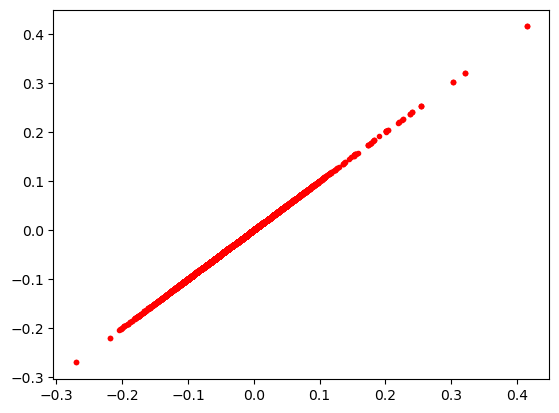

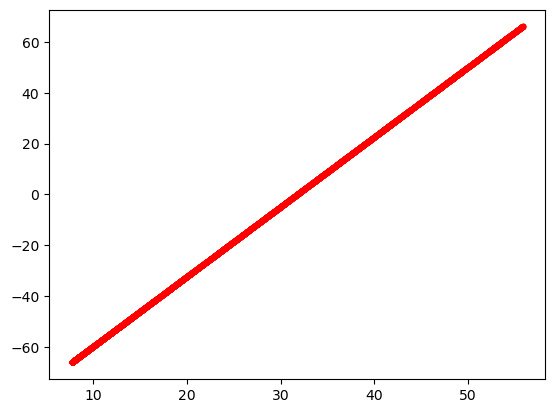

In [21]:
plt.plot(alongtrack_convert_up(ss_da), tmp.SSH_at_xy[np.isfinite(tmp.SSH_at_xy)][::k], 'r.')
plt.figure();
plt.plot(alongtrack_convert_up(ll_da), tmp.lat[np.isfinite(tmp.SSH_at_xy)][::k], 'r.')


In [22]:
def shrink_alongtrack_files(file_path, output_path, skip=5, save=True):
    orig_filename = file_path.name
    new_filename = orig_filename[:-3] + '_small.nc'
    print(orig_filename, new_filename)

    tmp = xr.open_dataset(file_path)
    
    ss = alongtrack_convert_down(tmp.SSH_at_xy.values);
    ll = lat_convert_down(tmp.lat.values)

    if (len(ss)==1 and ss == -1) or (len(ll)==1 and ll == -1):
        print('error with ', file_path)
        return 0
    else:
        ss_da = xr.DataArray(ss, dims=['i']); ss_da.name = 'ss'
        ll_da = xr.DataArray(ll, dims=['i']); ll_da.name = 'll'
        
        print(len(ss_da))
        ss_da = ss_da[np.isfinite(tmp.SSH_at_xy.values)][::skip]
        ll_da = ll_da[np.isfinite(tmp.SSH_at_xy.values)][::skip]
        print(len(ss_da))
        
        tmp_small = xr.merge([ss_da,ll_da])
        tmp_small['time'] = tmp.time

        #print(tmp_small)
        comp = dict(zlib=True, complevel=5)
        encoding = {var: comp for var in tmp_small.data_vars}

        #print(encoding)
        output_filename = output_path / new_filename
        #print(output_filename)

        tmp_small.to_netcdf(output_filename, encoding=encoding)
        tmp_small.close()

        return 1

In [23]:
err_code = shrink_alongtrack_files(sev_files[0], output_path);
print(err_code)

ECCO_V4r4_alongtrack_SSH_1992-09-23.nc ECCO_V4r4_alongtrack_SSH_1992-09-23_small.nc
0.00028614124 0.0009998828 0.02377073705907776
0.0007949887 0.0027503967 0.0
60158
11746
1


In [24]:
for file in sev_files:
    code = shrink_alongtrack_files(file, output_path);
    if code == 0:
        print('error at ', file)
        break;

ECCO_V4r4_alongtrack_SSH_1992-09-23.nc ECCO_V4r4_alongtrack_SSH_1992-09-23_small.nc
0.00028614124 0.0009998828 0.02377073705907776
0.0007949887 0.0027503967 0.0
60158
11746
ECCO_V4r4_alongtrack_SSH_1992-09-24.nc ECCO_V4r4_alongtrack_SSH_1992-09-24_small.nc
0.00028679648 0.0009996071 0.027659400767409584
0.00079321774 0.0027542114 0.0
61245
11911
ECCO_V4r4_alongtrack_SSH_1992-09-25.nc ECCO_V4r4_alongtrack_SSH_1992-09-25_small.nc
0.00028991367 0.0009996071 0.023087553857409966
0.0007933873 0.0027542114 0.0
61505
12017
ECCO_V4r4_alongtrack_SSH_1992-09-26.nc ECCO_V4r4_alongtrack_SSH_1992-09-26_small.nc
0.0002883269 0.0009998456 0.025511707876207632
0.0007940599 0.0027542114 0.0
61070
11903
ECCO_V4r4_alongtrack_SSH_1992-09-27.nc ECCO_V4r4_alongtrack_SSH_1992-09-27_small.nc
0.00028882074 0.0009997971 0.025612149683065737
0.00079324626 0.0027542114 0.0
62158
12114
ECCO_V4r4_alongtrack_SSH_1992-09-28.nc ECCO_V4r4_alongtrack_SSH_1992-09-28_small.nc
0.00028884097 0.0009999312 0.02338164884895389